## Notebook to calculate T1 anisotropy 
based on CSA   
using diffusion on a cone model   

In [104]:
# CSA parameters
iso_val = 170
delta_xx_val = 95
delta_yy_val = 190
delta_zz_val = 3 * iso_val - delta_xx_val - delta_yy_val  # 510 - 285 = 225
delta_val = iso_val -delta_zz_val  # 170 - 225 = -55


import numpy as np
# simulate a diffusion on a cone model 
def simulate_vector_on_cone(S2=0.85, tau_c=0.01, dt=1e-4, num_steps=10000, axis=np.array([0, 0, 1])):
    """
    Simulate a unit vector hopping on a cone surface with fixed S2 and correlation time tau_c.
    
    Returns:
        vectors: (num_steps, 3) array of unit vectors
    """
    # Cone angle from S²
    cos_theta = np.sqrt((2 * S2 + 1) / 3)
    theta = np.arccos(cos_theta)

    # Ornstein-Uhlenbeck parameters for azimuthal diffusion
    gamma = 1 / tau_c
    sigma = np.sqrt(2 * gamma)  # Unit noise strength
    phi = 0.0
    axis = axis / np.linalg.norm(axis)

    # Rotation matrix to align cone with axis
    R_align = rotation_matrix_from_vectors(np.array([0, 0, 1]), axis)

    vectors = np.zeros((num_steps, 3))

    for i in range(num_steps):
        # Update azimuthal angle using Ornstein-Uhlenbeck process
        dphi = -gamma * phi * dt + sigma * np.sqrt(dt) * np.random.randn()
        phi += dphi

        # Point on cone with fixed θ and current φ
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        vec_local = np.array([x, y, z])

        # Rotate to align cone with specified axis
        vec_global = R_align @ vec_local
        vectors[i] = vec_global

    return vectors

def rotation_matrix_from_vectors(a, b):
    """Find the rotation matrix that aligns vector a to vector b"""
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    v = np.cross(a, b)
    c = np.dot(a, b)
    if c == 1:
        return np.eye(3)
    if c == -1:
        # 180° rotation around arbitrary perpendicular axis
        perp = np.array([1, 0, 0]) if not np.allclose(a, [1, 0, 0]) else np.array([0, 1, 0])
        return rotation_matrix_from_vectors(a, np.cross(a, perp))
    s = np.linalg.norm(v)
    vx = np.array([[0, -v[2], v[1]],
                   [v[2], 0, -v[0]],
                   [-v[1], v[0], 0]])
    return np.eye(3) + vx + vx @ vx * ((1 - c) / (s**2))




In [105]:
# to make the trajactory T1 sensitive, simulate with 
vecs = simulate_vector_on_cone(S2=0.85, tau_c=1e-9, dt=5e-11, num_steps=2000)


In [106]:
# write it as a module 
import sympy as sp
from sympy.physics.quantum.spin import Rotation

# Define symbolic variables for Euler angles and tensor coefficients
alpha, beta, gamma = sp.symbols('alpha beta gamma', real=True)
iso, delta_xx, delta_yy, delta_zz = sp.symbols('iso delta_xx delta_yy delta_zz', real=True)

CSA_T_2m = {
    '-2': 0.5 * (delta_xx - delta_yy),
    '-1': 0,
    '0': sp.sqrt(3/2) * (delta_zz-(delta_xx + delta_yy + delta_zz)/3),
    '1': 0,
    '2': 0.5 * (delta_xx - delta_yy)
}

Dipolar_T_2m = {
    '-2': -sp.sqrt(3/8),
    '-1': 0,
    '0': sp.sqrt(1/2),
    '1': 0,
    '2': -sp.sqrt(3/8)
}

# Construct the full Wigner D-matrix for l=2
m_values = [-2, -1, 0, 1, 2]
D_2 = sp.zeros(5, 5)
for i, m1 in enumerate(m_values):
   for j, m2 in enumerate(m_values):
       D_2[i, j] = sp.exp(-sp.I * m1 * alpha) * Rotation.d(2,m1,m2,beta) * sp.exp(-sp.I * m2 * gamma)


# # Define the transformation of T_{2m} under the Wigner D-matrix
def transform_tensor(T_2m, D_matrix):
    m_values = ['-2', '-1', '0', '1', '2']
    T_2m_matrix = sp.Matrix([T_2m[m] for m in m_values])
    T_transformed = D_matrix * T_2m_matrix
    T_transformed = sp.simplify(T_transformed)
    return T_transformed



from scipy.spatial.transform import Rotation as R
import numpy as np

def calculate_euler_angles(ori_t, convention='ZYZ'):
    """
    Calculate Euler angles from orientation matrices.

    Parameters:
        ori_t (np.ndarray): Orientation matrices, shape (num_frames, num_residues, 3, 3).
        convention (str): Euler angle convention, e.g., 'ZYX', 'ZXZ', etc.

    Returns:
        np.ndarray: Euler angles, shape (num_frames, num_residues, 3) for yaw, pitch, roll in radians.
    """
    num_frames, num_residues = ori_t.shape[:2]
    euler_angles = np.zeros((num_frames, num_residues, 3))
    
    for frame in range(num_frames):
        for residue in range(num_residues):
            # Extract the 3x3 rotation matrix for this frame and residue
            rotation_matrix = ori_t[frame, residue]
            # Convert to Euler angles in radians
            euler_angles[frame, residue] = R.from_matrix(rotation_matrix).as_euler(convention, degrees=True) * np.pi / 180

    return euler_angles


def generate_local_axes(vectors):
    """
    Generate local orthonormal (x, y, z) axes for each vector.

    Parameters
    ----------
    vectors : np.ndarray, shape (N, n_res, 3)
        Array of position vectors (not necessarily normalized).

    Returns
    -------
    local_axes : np.ndarray, shape (N, n_res, 3, 3)
        Local orthonormal axes [x, y, z] for each vector.
        Each 3x3 block is a rotation matrix with columns (x̂, ŷ, ẑ).
    """
    vectors = np.asarray(vectors, dtype=float)
    N, n_res = vectors.shape[:2]

    # Normalize vectors → z axes
    z_axes = vectors / np.linalg.norm(vectors, axis=-1, keepdims=True)
    z_global = np.array([0.0, 0.0, 1.0])

    x_axes = np.zeros_like(z_axes)
    y_axes = np.zeros_like(z_axes)

    for i in range(N):
        for j in range(n_res):
            z = z_axes[i, j]

            # Handle edge case: z nearly parallel to global z
            if np.allclose(np.abs(np.dot(z, z_global)), 1.0, atol=1e-6):
                ref = np.array([1.0, 0.0, 0.0])
            else:
                ref = z_global

            # Compute local x̂
            x = np.cross(ref, z)
            x_norm = np.linalg.norm(x)
            if x_norm < 1e-12:  # safety
                x = np.array([1.0, 0.0, 0.0])
            else:
                x /= x_norm

            # Compute local ŷ (right-handed)
            y = np.cross(z, x)
            y /= np.linalg.norm(y)

            x_axes[i, j] = x
            y_axes[i, j] = y

    # Stack as (N, n_res, 3, 3): columns = [x̂, ŷ, ẑ]
    local_axes = np.stack((x_axes, y_axes, z_axes), axis=2)

    return local_axes



In [107]:
# covert vecs to euler angles
# additional dimension for num_residues=1
# add dim in axis 1, try avoid adding axis over agian for new excution
vecs = np.expand_dims(vecs, axis=1)
ori_t = generate_local_axes(vecs)
#print(ori_t.shape)
euler_angles = calculate_euler_angles(ori_t)


In [108]:
csa_h = transform_tensor(CSA_T_2m, D_2)
dipolar_h = transform_tensor(Dipolar_T_2m, D_2)

In [109]:
csa_h

Matrix([
[(0.5*(delta_xx - delta_yy)*(-cos(beta)/2 + cos(2*beta)/8 + 3/8)*exp(2*I*alpha) + (0.5*(delta_xx - delta_yy)*(cos(beta)/2 + cos(2*beta)/8 + 3/8)*exp(2*I*(alpha + gamma)) - sqrt(6)*(0.408248290463863*delta_xx + 0.408248290463863*delta_yy - 0.816496580927726*delta_zz)*exp(2*I*alpha)*sin(beta)**2/4)*exp(2*I*gamma))*exp(-2*I*gamma)],
[                    (0.5*(delta_xx - delta_yy)*(sin(beta)/2 - sin(2*beta)/4)*exp(I*alpha) + (-0.25*(delta_xx - delta_yy)*(cos(beta) + 1)*exp(I*(alpha + 2*gamma))*sin(beta) - sqrt(6)*(0.408248290463863*delta_xx + 0.408248290463863*delta_yy - 0.816496580927726*delta_zz)*exp(I*alpha)*sin(2*beta)/4)*exp(2*I*gamma))*exp(-2*I*gamma)],
[                                                                  (0.125*sqrt(6)*(delta_xx - delta_yy)*sin(beta)**2 + (0.125*sqrt(6)*(delta_xx - delta_yy)*exp(2*I*gamma)*sin(beta)**2 - (3*cos(2*beta)/4 + 1/4)*(0.408248290463863*delta_xx + 0.408248290463863*delta_yy - 0.816496580927726*delta_zz))*exp(2*I*gamma))*exp(-2*I*gamm

In [120]:
csa_h[4]

(0.5*(delta_xx - delta_yy)*(cos(beta)/2 + cos(2*beta)/8 + 3/8)*exp(2*I*alpha) + (0.5*(delta_xx - delta_yy)*(-cos(beta)/2 + cos(2*beta)/8 + 3/8)*exp(2*I*gamma) - sqrt(6)*(0.408248290463863*delta_xx + 0.408248290463863*delta_yy - 0.816496580927726*delta_zz)*sin(beta)**2/4)*exp(2*I*(alpha + gamma)))*exp(-2*I*(2*alpha + gamma))

In [121]:
# calculate Y_l^m series with lambdify
CSA_Y_lm=[]
l=2
for m in range(-l, l+1):
     expr = csa_h[m+l]  # m=0 corresponds to index 2
     cas_m_expr_func = sp.lambdify((alpha, beta, gamma, delta_xx, delta_yy, delta_zz), expr, modules="numpy")
     CSA_Y_lm.append(cas_m_expr_func)

#cas_0_expr_func = sp.lambdify((alpha, beta, gamma, iso delta_xx, delta_yy, delta_zz), expr, modules="numpy")
# calculate values
CSA_Y_lm_value = {}
for m in range(-l, l+1):
    expr_func = CSA_Y_lm[m+l]
    value_m = expr_func(
        euler_angles[:, :, 0],
        euler_angles[:, :, 1],
        euler_angles[:, :, 2],
        delta_xx_val,
        delta_yy_val,
        delta_zz_val
    )
    # Convert to float in case of complex small imaginary parts
    value_m = np.real(value_m)
    CSA_Y_lm_value[m] = value_m




Text(0.5, 0, 'Frame')

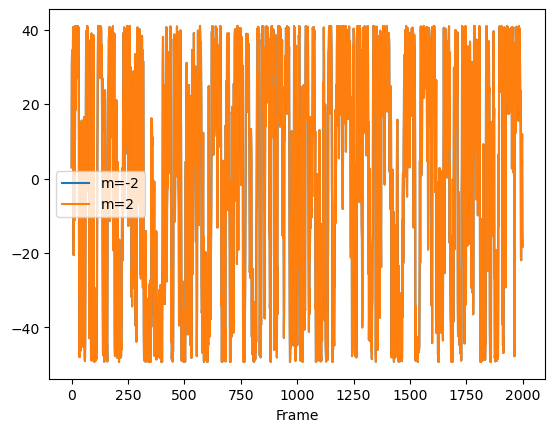

In [130]:
# plot Y_2, -1 and Y2, 1
#plt.plot(np.arange(CSA_Y_lm_value[1].shape[0]), np.real(CSA_Y_lm_value[1][:,0]), label='m=1')
#plt.plot(np.arange(CSA_Y_lm_value[-1].shape[0]), np.real(CSA_Y_lm_value[-1][:,0]), label='m=-1')
##plt.plot(np.arange(CSA_Y_lm_value[0].shape[0]), np.real(CSA_Y_lm_value[0][:,0]), label='m=0')
plt.plot(np.arange(CSA_Y_lm_value[-2].shape[0]), np.real(CSA_Y_lm_value[-2][:,0]), label='m=-2')
plt.plot(np.arange(CSA_Y_lm_value[2].shape[0]), np.real(CSA_Y_lm_value[2][:,0]), label='m=2')
plt.legend()
plt.xlabel('Frame')

In [96]:
for key in CSA_Y_lm_value.keys(): 
    print(key)

-2
-1
0
1
2


Part III. calculate correlation matrix

In [97]:
def compute_correlation_matrix(Y_series, max_lag=1000):
    l = max(Y_series.keys())
    corr_matrix = {}
    for m1 in range(-l, l + 1):
        for m2 in range(-l, l + 1):
            corr = []
            y1 = Y_series[m1]
            y2 = Y_series[m2]
            for tau in range(max_lag//10):
                val = np.mean(y1[:-tau or None] * np.conj(y2[tau:])) if tau > 0 else np.mean(y1 * np.conj(y2))
                corr.append(val)
            corr_matrix[(m1, m2)] = np.array(corr)
    return corr_matrix



In [131]:
csa_autocorrelation_L=compute_correlation_matrix(CSA_Y_lm_value, max_lag=1000)

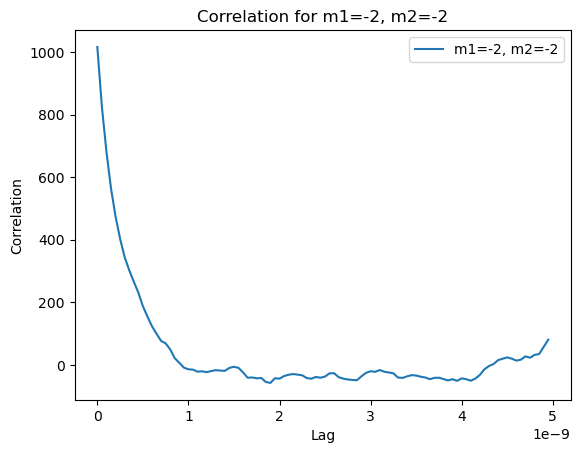

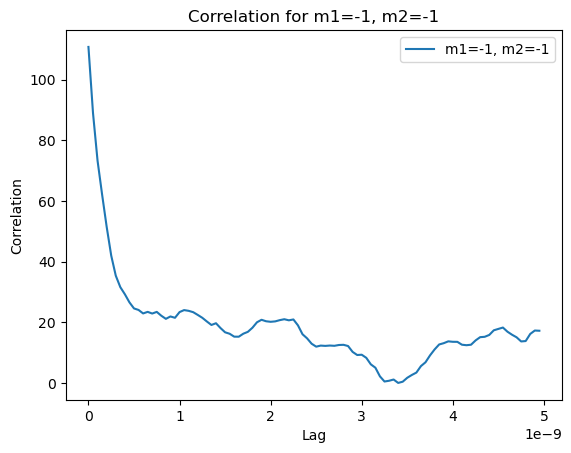

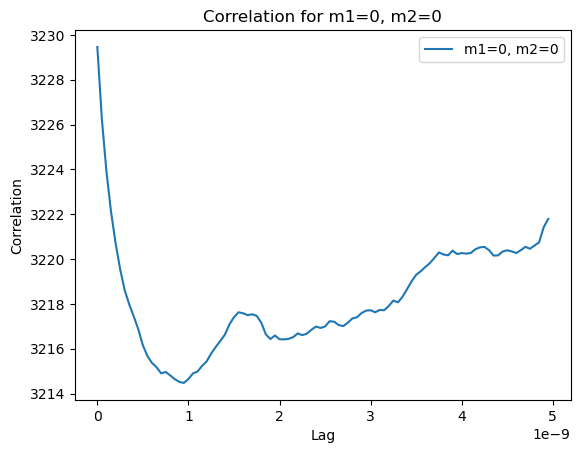

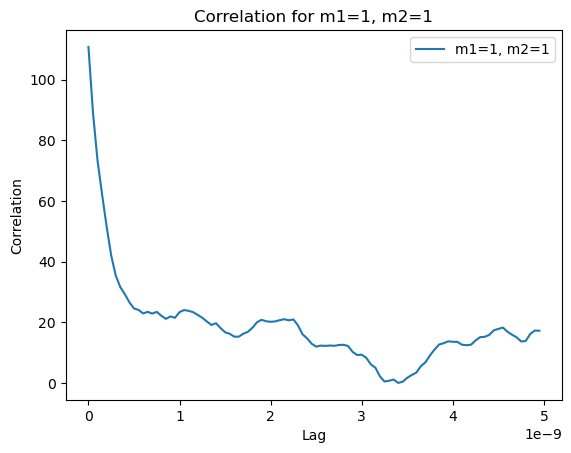

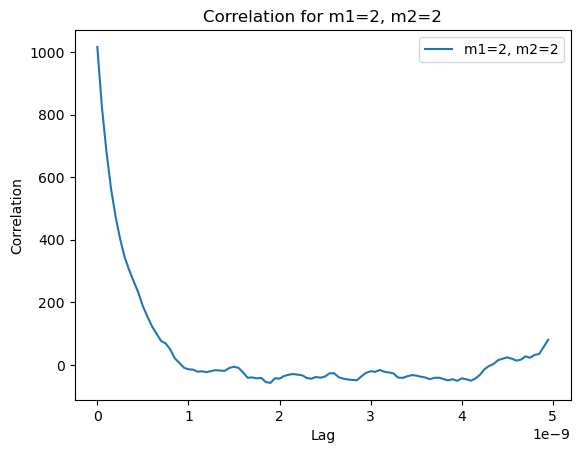

In [132]:
# plot correlation matrix
dt =5e-11
for (m1, m2), corr in csa_autocorrelation_L.items():
    if m1 != m2:
        continue
    plt.plot(np.arange(corr.shape[0])*dt, corr, label=f'm1={m1}, m2={m2}')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.title(f'Correlation for m1={m1}, m2={m2}')
    plt.legend()
    plt.show()  

Part IV, ensemble 

In [3]:
# calculate autocorrelation function for spherical harmonics for all m values
from scipy.special import sph_harm

def compute_sph_harm_autocorrelation(vectors, l=2, m=0):
    """
    Compute complex autocorrelation of Y_l^m spherical harmonics from vector trajectory.
    
    Parameters:
        vectors: (num_steps, 3) array of unit vectors
        l: degree of spherical harmonics
        m: order of spherical harmonics

    Returns:
        corr: autocorrelation values
    """
    N = len(vectors)
    theta = np.arccos(vectors[:, 2])  # z = cos(theta)
    phi = np.arctan2(vectors[:, 1], vectors[:, 0])  # arctangent of y/x

    Y_vals = sph_harm(m, l, phi, theta)

    corr = []
    for tau in range(N // 10):
        if tau == 0:
            c = np.abs(np.mean(Y_vals * np.conj(Y_vals)))  # Normalization
        else:
            c = np.mean(Y_vals[:-tau] * np.conj(Y_vals[tau:]))
        corr.append(np.real(c))  # or keep complex values
    return np.array(corr)

def compute_correlation_matrix(Y_series, max_lag=1000):
    l = max(Y_series.keys())
    corr_matrix = {}
    for m1 in range(-l, l + 1):
        for m2 in range(-l, l + 1):
            corr = []
            y1 = Y_series[m1]
            y2 = Y_series[m2]
            for tau in range(max_lag//10):
                val = np.mean(y1[:-tau or None] * np.conj(y2[tau:])) if tau > 0 else np.mean(y1 * np.conj(y2))
                corr.append(val)
            corr_matrix[(m1, m2)] = np.array(corr)
    return corr_matrix

In [4]:
Y_series = {}
for m in range(-2, 3):
    Y_series[m] = compute_sph_harm_autocorrelation(vecs, l=2, m=m)
corr_matrix = compute_correlation_matrix(Y_series, max_lag=2000)


Text(0.5, 1.0, 'Autocorrelation of Spherical Harmonic Y_2^0')

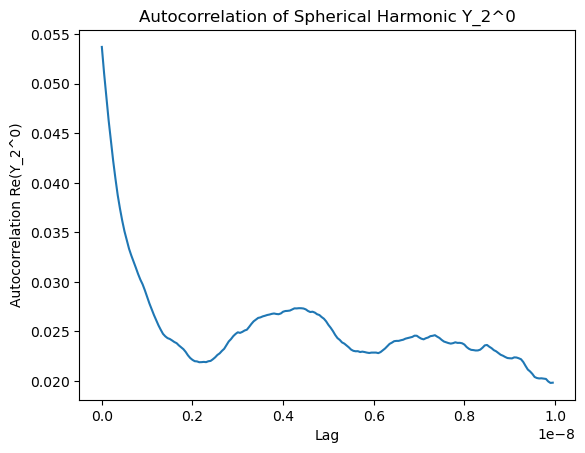

In [7]:
# plot one of teh Y series
import matplotlib.pyplot as plt 
dt = 5e-11
plt.plot(np.arange(len(Y_series[1].real))*dt, Y_series[1].real)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Re(Y_2^0)')
plt.title('Autocorrelation of Spherical Harmonic Y_2^0')

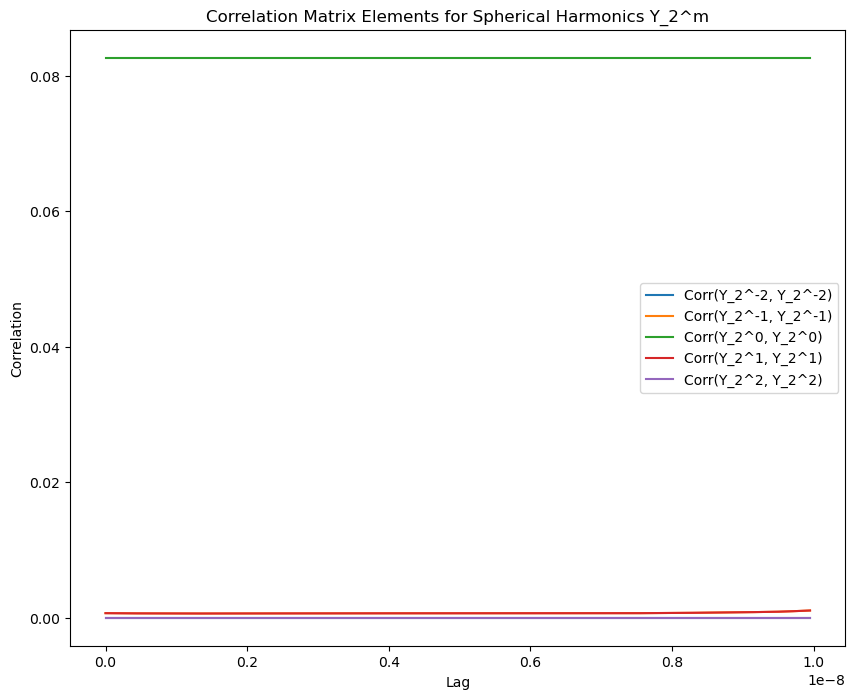

In [9]:
# plot correlation matrix elements
plt.figure(figsize=(10, 8))
# plot only m1 = m2
for (m1, m2), corr in corr_matrix.items():
    if m1 == m2:
        plt.plot(np.arange(len(corr))*dt, corr.real, label=f'Corr(Y_2^{m1}, Y_2^{m2})')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Correlation Matrix Elements for Spherical Harmonics Y_2^m')
plt.legend()
plt.show()  

In [ ]:
# Number of random rotations
N = 100

# Sample random rotations from SO(3)
rot = R.random(num=N)

# Extract Euler angles (zyz convention)
alpha_vals, beta_vals, gamma_vals = rot.as_euler('zyz', degrees=False).T

# generate autocorrelation functions for m=-1 for each orientation

{(-2, -2): array([ 4.32493684e-08,  3.72943225e-08,  3.24248499e-08,  2.84324951e-08,
        2.51743613e-08,  2.25016799e-08,  2.04354554e-08,  1.88223897e-08,
        1.76618626e-08,  1.67200384e-08,  1.59359327e-08,  1.52944937e-08,
        1.47549318e-08,  1.43671298e-08,  1.39945772e-08,  1.36130198e-08,
        1.32174323e-08,  1.28392822e-08,  1.24372366e-08,  1.20307719e-08,
        1.16522747e-08,  1.13400525e-08,  1.10839743e-08,  1.07844117e-08,
        1.04448347e-08,  1.00875194e-08,  9.71656697e-09,  9.40247245e-09,
        9.18525414e-09,  9.02154534e-09,  8.88289748e-09,  8.67875748e-09,
        8.37372287e-09,  7.98101943e-09,  7.56869695e-09,  7.21016743e-09,
        6.97428169e-09,  6.79212730e-09,  6.63703410e-09,  6.56637649e-09,
        6.62520404e-09,  6.76811553e-09,  7.05467481e-09,  7.37638306e-09,
        7.73919006e-09,  8.19663229e-09,  8.67872421e-09,  9.15771822e-09,
        9.70513504e-09,  1.03399098e-08,  1.08513088e-08,  1.12653668e-08,
        1.1607

In [ ]:
# generate random orientations on a SO3 surface
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# Number of random rotations
N = 100

# Sample random rotations from SO(3)
rot = R.random(num=N)

# Extract Euler angles (zyz convention)
alpha_vals, beta_vals, gamma_vals = rot.as_euler('zyz', degrees=False).T

# compute autocorrelation function for spherical harmonics m=-1 for each orientation using wigner D-matrix
# further calculate T1 value for that orientation


# Another way to compute autocorrelation using spherical harmonics
from scipy.special import sph_harm




# calculate chemical shift value for each orientation


# plot chemical shift vs T1 values